# Primal Dual

# Projection onto the simplex



<div class="alert alert-block alert-success">
This notebook implements an algorithm for the projection of a vector $y$ onto the simplex $\Delta$ with
\begin{align}
    \Delta := \Big\{ (x_1,\ldots,x_N)\in \mathbb{R}^N:\, \sum_{n=1}^N x_n =a \quad\text{and}\quad x\geq 0 \Big\}.
\end{align}
    
The implemented algorithm was proposed in: Condat, L. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). 
    
The paper is also available at [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Condat's Algorithm</h2>
<ol>
<li>Set $v:= (y_1)$, $u$ as an empty list, $\rho:= y_1 - a$.</li>
<li>For $n \in \{2,\ldots, N\}$, do
<ol>
<li>If $y_n > \rho$
<ol>
<li>Set $\rho := \rho + (y_n - \rho)/(|v|+1)$.</li>
<li>If $\rho > y_n - a$, add $y_n$ to $v$.</li>
<li>Else, add $v$ to $u$, set $v = (y_n)$, $\rho = y_n -a$.</li>
</ol>
</li>
</ol>
</li>
<li>If $u$ is not empty, for every element $y$ of $u$, do
<ol>
<li>If $y > \rho$, add $y$ to $v$ and set $\rho := \rho + (y-\rho)/|v|$.</li>
</ol>
</li>
<li>Do, while $|v|$ changes,
<ol>
<li>For every element $y$ of $v$ do
<ol>
<li>If $y\leq \rho$, remove $y$ from $v$ and set $\rho := \rho + (\rho - y)/|v|$.</li>
</ol>
</li>
</ol>
</li>
<li>Set $\tau := \rho$, $K = |v|$.</li>
<li>For $n \in \{1,\ldots,N\}$, set $x_n := \max \{y_n - \tau, 0\}$.</li>
</ol>
</div>

The algorithm will be tested projecting a random vector $y$ of size $N$ where $y_n \sim \mathcal{U}(-1,2)$ for all $n\in \{1,\ldots,N\}$.

In [1]:
import numpy as np
from numpy import nditer, ndenumerate, zeros, zeros_like, clip, allclose, full, maximum
from numpy.random import default_rng as rng

In [2]:
N = 1000
y = rng(0).uniform(-1,2,N)
a = 1.0

## List version

<div class="alert alert-block alert-info">
First implementation is list-based. It sticks to the algorithm above, and thus it cannot take the advantage that $v$ is the list of positive values of $y$, thus requiring the unnecessary triming in Step 6.
</div>

In [3]:
# Step 1
v = [y[0]]
u = []
ρ = y[0] - a

In [4]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( len(v) + 1 )
        if ρ > yₙ - a:
            v.append(yₙ)
        else:
            u.extend(v)
            v = [yₙ]
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for ι in iter(u):
        if ι > ρ:
            v.append(ι)
            ρ += (ι - ρ)/( len(v) )
# Step 4
while True:
    ℓ_v = len(v)
    for ı in range(ℓ_v - 1, -1, -1):
        if v[ı] <= ρ:
            ρ += (ρ - v[ı])/(len(v) - 1)
            del v[ı]
    if len(v) >= ℓ_v:
        break

In [5]:
x = clip(y - ρ, 0, None)

In [6]:
v - ρ

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

## Vectorial version 1

<div class="alert alert-block alert-info">
The following adaptation introduces some array operations to avoid the extra step of clipping negative numbers. Here $v$ is not a set but a boolean array of the same size as $y$. Its cells determine if a cell of $y$ is active in $v$ or not. In the end, $x$ is computed just on the active cells given by $v$.
</div>

In [7]:
# Step 1
ρ = y[0] - a

v = zeros(N, dtype=bool)
x = zeros_like(y)
u = []
v[0] = True

In [8]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( v.sum() + 1 )
        if ρ > yₙ - a:
            v[n] = True
        else:
            u.extend([i[0] for i,j in ndenumerate(v) if j])
            v *= False;    v[n] = True
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for n in iter(u):
        yₙ = y[n]
        if yₙ > ρ:
            v[n] = True
            ρ += (yₙ - ρ)/( v.sum() )
# Step 4
while True:
    ℓ_v = v.sum()
    for i,j in ndenumerate(v):
        if j:
            if y[i[0]] <= ρ:
                ρ += (ρ - y[i[0]])/(v.sum() - 1)
                v[i[0]] = False
    if v.sum() >= ℓ_v:
        break

In [9]:
x[v] = y[v] - ρ #clip(y[v] - ρ, 0.0, None)

In [10]:
x[v]

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

## Vectorial version 2

<div class="alert alert-block alert-info">
The final implementation takes back the original idea of using lists instead of an array of the same size as $y$. In this case, $v$ does not contain values from $y$ but its indeces. This way a sparse representation of $v$ is achieved and $x$ does not go through a clipping step as well.
</div>

In [11]:
# Step 1
ρ = y[0] - a

x = zeros_like(y)
v = [0]
u = []

In [12]:
# Step 2
for n in range(1,N):
    yₙ = y[n]
    if yₙ > ρ:
        ρ += (yₙ - ρ)/( len(v) + 1 )
        if ρ > yₙ - a:
            v.append(n)
        else:
            u.extend(v)
            v = [n]
            ρ = yₙ - a
# Step 3
if len(u) > 0:
    for n in iter(u):
        yₙ = y[n]
        if yₙ > ρ:
            v.append(n)
            ρ += (yₙ - ρ)/( len(v) )
# Step 4
while True:
    ℓ_v = len(v)
    for i,j in enumerate(v):
        if y[j] <= ρ:
            ρ += (ρ - y[j])/(len(v) - 1)
            del v[i]
    if len(v) >= ℓ_v:
        break

In [13]:
x[v] = y[v] - ρ #clip(y[v] - ρ, 0.0, None)

In [14]:
x[v]

array([0.06744738, 0.01832359, 0.06110709, 0.01940269, 0.00520454,
       0.06056962, 0.02164565, 0.01061472, 0.04190357, 0.05789789,
       0.02130254, 0.0148837 , 0.06684845, 0.05188726, 0.00241651,
       0.04805173, 0.0173415 , 0.02582169, 0.03312648, 0.07432163,
       0.02410941, 0.01056192, 0.03883018, 0.03691761, 0.05087173,
       0.00455268, 0.06171698, 0.05232123])

---

## Performance tests

<div class="alert alert-block alert-warning">
Now we check which routine is the fastest.
</div>

In [15]:
def CondatP_a(y,a,N):
    # Step 1
    v = [y[0]]
    u = []
    ρ = y[0] - a
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(yₙ)
            else:
                u.extend(v)
                v = [yₙ]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for ι in iter(u):
            if ι > ρ:
                v.append(ι)
                ρ += (ι - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for ı in range(ℓ_v - 1, -1, -1):
            if v[ı] <= ρ:
                ρ += (ρ - v[ı])/(len(v) - 1)
                del v[ı]
        if len(v) >= ℓ_v:
            break
            
    return clip(y - ρ, 0, None)

def CondatP_b(y,a,N):
    # Step 1
    ρ = y[0] - a

    v = zeros(N, dtype=bool)
    x = zeros_like(y)
    u = []
    v[0] = True
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( v.sum() + 1 )
            if ρ > yₙ - a:
                v[n] = True
            else:
                u.extend([i[0] for i,j in ndenumerate(v) if j])
                v *= False;    v[n] = True
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v[n] = True
                ρ += (yₙ - ρ)/( v.sum() )
    # Step 4
    while True:
        ℓ_v = v.sum()
        for i,j in ndenumerate(v):
            if j:
                if y[i[0]] <= ρ:
                    ρ += (ρ - y[i[0]])/(v.sum() - 1)
                    v[i[0]] = False
        if v.sum() >= ℓ_v:
            break

    x[v] = y[v] - ρ 
    return x

def CondatP_c(y,a,N):
    # Step 1
    ρ = y[0] - a

    x = zeros_like(y)
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    x[v] = y[v] - ρ
    return x

In [16]:
%timeit -r 10 -n 200 CondatP_a(y,a,N)

272 µs ± 44.6 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


In [17]:
%timeit -r 10 -n 200 CondatP_b(y,a,N)

1.45 ms ± 51.7 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


In [18]:
%timeit -r 10 -n 200 CondatP_c(y,a,N)

277 µs ± 7.86 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


As we can see, the last implementation might be a little faster than the original.

---

## Just-in-time compilation with numba

<div class="alert alert-block alert-warning">
We use numba to speed up the computation time.
</div>

In [19]:
from numba import jit, prange

In [20]:
@jit(nopython=True, fastmath = True, parallel = True)
def CondatP_a(y,a,N):
    # Step 1
    v = [y[0]]
    u = []
    ρ = y[0] - a
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(yₙ)
            else:
                u.extend(v)
                v = [yₙ]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for ι in iter(u):
            if ι > ρ:
                v.append(ι)
                ρ += (ι - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for ı in range(ℓ_v - 1, -1, -1):
            if v[ı] <= ρ:
                ρ += (ρ - v[ı])/(len(v) - 1)
                del v[ı]
        if len(v) >= ℓ_v:
            break
            
    return maximum(y - ρ, 0)

In [21]:
@jit(nopython=True, fastmath = True, parallel = True)
def CondatP_b(y,a,N):
    # Step 1
    ρ = y[0] - a

    v = full(N, False)
    x = zeros_like(y)
    u = []
    v[0] = True
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( v.sum() + 1 )
            if ρ > yₙ - a:
                v[n] = True
            else:
                u.extend([i[0] for i,j in ndenumerate(v) if j])
                v *= False;    v[n] = True
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v[n] = True
                ρ += (yₙ - ρ)/( v.sum() )
    # Step 4
    while True:
        ℓ_v = v.sum()
        for i,j in ndenumerate(v):
            if j:
                if y[i[0]] <= ρ:
                    ρ += (ρ - y[i[0]])/(v.sum() - 1)
                    v[i[0]] = False
        if v.sum() >= ℓ_v:
            break

    x[v] = y[v] - ρ 
    return x

In [22]:
@jit(nopython=True, fastmath = True)#, parallel = True)
def CondatP_c(y,a,N):
    # Step 1
    ρ = y[0] - a

    x = zeros_like(y)
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [23]:
# Run things once for pre-compiling:
CondatP_a(y,a,N), CondatP_b(y,a,N), CondatP_c(y,a,N);

Now we see a clear winner.

In [24]:
%timeit -r 10 -n 200 CondatP_a(y,a,N)

11.6 µs ± 966 ns per loop (mean ± std. dev. of 10 runs, 200 loops each)


In [25]:
%timeit -r 10 -n 200 CondatP_b(y,a,N)

441 µs ± 18.2 µs per loop (mean ± std. dev. of 10 runs, 200 loops each)


In [26]:
%timeit -r 10 -n 200 CondatP_c(y,a,N)

4.75 µs ± 405 ns per loop (mean ± std. dev. of 10 runs, 200 loops each)


Finally, a sanity check:

In [27]:
allclose(CondatP_a(y,a,N), CondatP_b(y,a,N)), allclose(CondatP_a(y,a,N), CondatP_c(y,a,N))

(True, True)

---

Now we can finally addapt the code to accept a matrix $\gamma$ as input.

In [28]:
N = 1000
M = 500
γ = rng(0).uniform(-1,2,(N,M))
a = 1.0

In [29]:
y = rng(0).uniform(-1,2,N)
x = zeros_like(γ)

In [30]:
@jit(nopython=True, fastmath = True)#, parallel = True)
def CondatP_c(y,x,a,N):
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [31]:
CondatP_c(y,x,a,N); # Null test

In [32]:
for i in range(N):
    x[i] = CondatP_c(γ[i],x[i],a,M)

In [33]:
# Just checking :)
for i in range(N):
    if x[i].sum() > 2:
        print(i)

26
27
77
94
163
171
194
198
239
252
275
278
308
349
368
405
412
414
497
530
698
734
736
745
762
790
799
812


In [34]:
x.sum(axis=1)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        , 33.17240125,  9.86861806,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

# Primal Dual

In [35]:
def primal_dual(c,m,n,iters):
    #Algorithm for calculating solution x, in the primal space
    #and y_1, y_2 in the dual space.
    #Also returns the value of the objective function c*x at each
    #iteration.
    
    #Initialise tau
    tau = 0.0001
    
    #Initialise sigma
    sig = 1/(tau*2) - 0.5
    
    #fetch lengths of m and n.
    N = np.size(n)
    M = np.size(m)
    
    #Initialise x
    x = np.zeros((M,N))
    x[:,0] = m
    x[0,:] = n
    x[0,0] = 0.5*(m[-1] + n[-1])
    
    #Initialise y_1 and y_2
    y_1 = np.zeros((M,N))
    y_2 = np.zeros((M,N))
    
    y_1[0,:] = n
    y_2[:,0] = m
    
    #Save that objective function
    obj = [np.sum(np.multiply(c,x))]
    
    
    for k in range(iters):
        #update x
        xnew = x - tau*c - tau*(y_1 + y_2)
        
        #matrices for projection over the simplex C_1^m and the simplex C_2^n.
        γ_1 = (1/sig)*y_1 + 2*xnew - x
        γ_2 = (1/sig)*y_2 + 2*xnew - x
        
        
        x_1 = zeros_like(γ_1)
        for i in range(M):
            x_1[i] = CondatP_c(γ_1[i],x_1[i],m[i],N)
        
        x_2 = zeros_like(γ_2)
        for i in range(N):
            x_2[:,i] = CondatP_c(γ_2[:,i],x_2[:,i],n[i],M)
            
        
        #update x using the projection over the simplex C_1^m
        y_1new = y_1 + sig*(2*xnew - x) - sig*x_1
  
        #update x using the projection over the simplex C_2^n
        y_2new = y_2 + sig*(2*xnew - x) - sig*x_2
        
        #Reset x,y_1, y_2 for the next iteration
        x = xnew
        y_1 = y_1new
        y_2 = y_2new
        
        #update objective function
        obj.append(np.sum(np.multiply(c,x)))
        
    return [x,obj]

In [36]:
import matplotlib.pyplot as plt
import time
x = np.linspace(0,1,1000)
y = np.linspace(1,2,1000)
len_x = np.size(x)
len_y = np.size(y)

c = np.zeros((len_x,len_y))
for i in range(len_x):
    for j in range(len_y):
        c[i,j] = (y[j]-x[i])**2

m = np.ones(len_x)/len_x
n = np.ones(len_y)/len_y
M = len_x
N = len_y

t = time.time()
[x,obj] = primal_dual(c,m,n,1000)
elapsed = time.time() - t
print('Time taken for Primal Dual =', elapsed)
print(obj[-1])
#plt.plot(obj)
#plt.imshow(x)

Time taken for Primal Dual = 167.865229845047
0.9998505213288531


## Exact Test

2.2314344522532625
[[0.05686586 0.06942852 0.05881085 0.06489476]
 [0.05456981 0.05775374 0.06479705 0.0728794 ]
 [0.05803672 0.05930167 0.06736664 0.06529497]
 [0.0805276  0.06351607 0.05902545 0.04693087]]


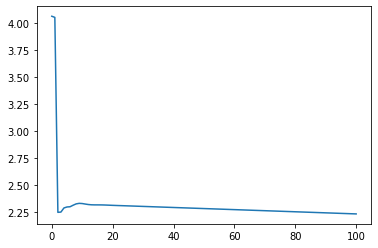

In [37]:
import matplotlib.pyplot as plt
#set parameters accordingly.
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])
[x,obj] = primal_dual(c,m,n,100)
plt.plot(obj)
print(obj[-1])
print(x)

## Generalised Forward-Backward Splitting

<div class="alert alert-block alert-success">
This implements a generalised forward-backward split approach for the OT problem.
    
The implemented algorithm was proposed in: Raguet. H, Fadili. J, Peyre. G <i>Generalised Forward-Backward Splitting</i>. SIAM Journal on Imaging Sciences. (2013)
    
A preprint of the paper is available at https://arxiv.org/pdf/1108.4404.pdf
</div>

In [47]:
def generalised_forward_backward(c,m,n,iters):
    #Algorithm for calculating solution x, in the primal space
    #and y_1, y_2 in the dual space.
    #Also returns the value of the objective function c*x at each
    #iteration.
    
    #First compute ?
    mu = np.linalg.norm(c,2)     # 1 -> 10^-1 -> 10^-2 -> ...
    # ? is selected as the midpoint of the interval
    #e = 1/mu #0.5 * 1/mu;        # remove
    # ? does not depend on the current iteration
    gam = 0.0001
    #likewise, we do not require a change in ?
    lam = 1.0;   #1.0
    
    #fetch lengths of m and n.
    N = np.size(n)
    M = np.size(m)
    
    #Initialise x
    #x = np.zeros((M,N))
    #x[:,0] = m
    #x[0,:] = n
    #x[0,0] = 0.5*(m[-1] + n[-1])
    
    #Initialise y_1 and y_2
    v_1 = np.zeros((M,N))
    v_2 = np.zeros((M,N))
    
    v_1[0,:] = n
    v_2[:,0] = m
    
    #Initialise x
    x = 0.5*(v_1 + v_2)
    
    #Save that objective function
    obj = [np.sum(np.multiply(c,x))]
    
   
    
    for k in range(iters):
    
        #matrices for projection over the simplex C_1^m and the simplex C_2^n.
        γ_1 = 2*x - v_1 - gam*c
        γ_2 = 2*x - v_2 - gam*c
        
        
        x_1 = zeros_like(γ_1)
        for i in range(M):
            x_1[i] = CondatP_c(γ_1[i],x_1[i],m[i],N)
        
        x_2 = zeros_like(γ_2)
        for i in range(N):
            x_2[:,i] = CondatP_c(γ_2[:,i],x_2[:,i],n[i],M)
            
        
        #update x using the projection over the simplex C_1^m
        v_1new = v_1 + lam*(x_1 - x)
  
        #update x using the projection over the simplex C_2^n
        v_2new = v_2  + lam*(x_2 - x)
        
        #Update x,v_1, v_2 for the next iteration
        v_1 = v_1new
        v_2 = v_2new
        x = 0.5*(v_1 + v_2)
        
        #update objective function
        obj.append(np.sum(np.multiply(c,x)))
        
        
    return [x,obj]

In [48]:
import matplotlib.pyplot as plt
x = np.linspace(0,1,1000)
y = np.linspace(1,2,1000)
len_x = np.size(x)
len_y = np.size(y)

c = np.zeros((len_x,len_y))
for i in range(len_x):
    for j in range(len_y):
        c[i,j] = (y[j]-x[i])**2

m = np.ones(len_x)/len_x
n = np.ones(len_y)/len_y
M = len_x
N = len_y


t = time.time()
[x,obj] = generalised_forward_backward(c,m,n,1000)
elapsed = time.time() - t
print('Time taken for Forward Backward =', elapsed)

print(obj[-1])
#plt.plot(obj)
#plt.imshow(x)

Time taken for Forward Backward = 164.32017993927002
0.9998751265540835


## Exact Test

1.2964068625
[[0.   0.25 0.   0.  ]
 [0.   0.   0.   0.25]
 [0.   0.   0.25 0.  ]
 [0.25 0.   0.   0.  ]]


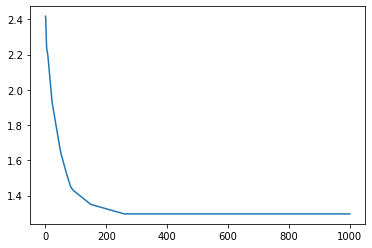

In [40]:
import matplotlib.pyplot as plt
M = 4                  
N = 4
m = 0.25*np.ones(M)
n = 0.25*np.ones(N)
c = np.array([[3.10112791, 2.01924761, 2.        , 2.01924761],
     [3.10112791, 3.        , 1.16637984, 1.        ],
     [3.        , 3.10112791, 1.16637984, 2.01924761],
     [1.        , 3.        , 2.33275967, 4.22075809]])
[x,obj] = generalised_forward_backward(c,m,n,1000)
plt.plot(obj)
print(obj[-1])
print(x)

---